## Processing the data

In [21]:
# List files in the data directory. 
!ls data/ml-latest-small/

README.txt  links.csv   movies.csv  ratings.csv tags.csv


In [5]:
movies = spark.read.csv("data/ml-latest-small/movies.csv", header=True, inferSchema=True)

In [7]:
movies.cache()
movies.show(5,truncate=False)

+-------+----------------------------------+-------------------------------------------+
|movieId|title                             |genres                                     |
+-------+----------------------------------+-------------------------------------------+
|1      |Toy Story (1995)                  |Adventure|Animation|Children|Comedy|Fantasy|
|2      |Jumanji (1995)                    |Adventure|Children|Fantasy                 |
|3      |Grumpier Old Men (1995)           |Comedy|Romance                             |
|4      |Waiting to Exhale (1995)          |Comedy|Drama|Romance                       |
|5      |Father of the Bride Part II (1995)|Comedy                                     |
+-------+----------------------------------+-------------------------------------------+
only showing top 5 rows



In [9]:
ratings = spark.read.csv("data/ml-latest-small/ratings.csv", header=True, inferSchema=True)

In [10]:
ratings.cache()
ratings.show(5,truncate=False)

+------+-------+------+---------+
|userId|movieId|rating|timestamp|
+------+-------+------+---------+
|1     |1      |4.0   |964982703|
|1     |3      |4.0   |964981247|
|1     |6      |4.0   |964982224|
|1     |47     |5.0   |964983815|
|1     |50     |5.0   |964982931|
+------+-------+------+---------+
only showing top 5 rows



In [13]:
movies.printSchema()
ratings.printSchema()

root
 |-- userId: integer (nullable = true)
 |-- movieId: integer (nullable = true)
 |-- rating: double (nullable = true)
 |-- timestamp: integer (nullable = true)

root
 |-- userId: integer (nullable = true)
 |-- movieId: integer (nullable = true)
 |-- rating: double (nullable = true)
 |-- timestamp: integer (nullable = true)



## Summarizing and Visulizing the data

In [16]:
ratings.describe().show()

+-------+------------------+----------------+------------------+--------------------+
|summary|            userId|         movieId|            rating|           timestamp|
+-------+------------------+----------------+------------------+--------------------+
|  count|            100836|          100836|            100836|              100836|
|   mean|326.12756356856676|19435.2957177992| 3.501556983616962|1.2059460873684695E9|
| stddev| 182.6184914635004|35530.9871987003|1.0425292390606342|2.1626103599513078E8|
|    min|                 1|               1|               0.5|           828124615|
|    max|               610|          193609|               5.0|          1537799250|
+-------+------------------+----------------+------------------+--------------------+



In [20]:
numRatings=ratings.count()
numUsers=ratings.select("userId").distinct().count()
numMovies=ratings.select("movieId").distinct().count()

print ("Number of different ratings: ",str(numRatings))
print ("Number of different users: ",str(numUsers))
print ("Number of different movies: ",str(numMovies))

numGoodMovies=ratings.filter("rating > 4").select("movieId").distinct().count()
print ("Number of movies with at least one rating strictly higher than 4: ",str(numGoodMovies))

Number of different ratings:  100836
Number of different users:  610
Number of different movies:  9724
Number of movies with at least one rating strictly higher than 4:  4056


In [25]:
movies_counts=ratings.select("movieId","rating").groupBy("movieId").\
    count().orderBy("movieId").toDF("movieId","counts")
movies_counts.show(5)

+-------+------+
|movieId|counts|
+-------+------+
|      1|   215|
|      2|   110|
|      3|    52|
|      4|     7|
|      5|    49|
+-------+------+
only showing top 5 rows



In [27]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
ratings_DF = ratings.toPandas()

In [28]:
ratings_DF.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


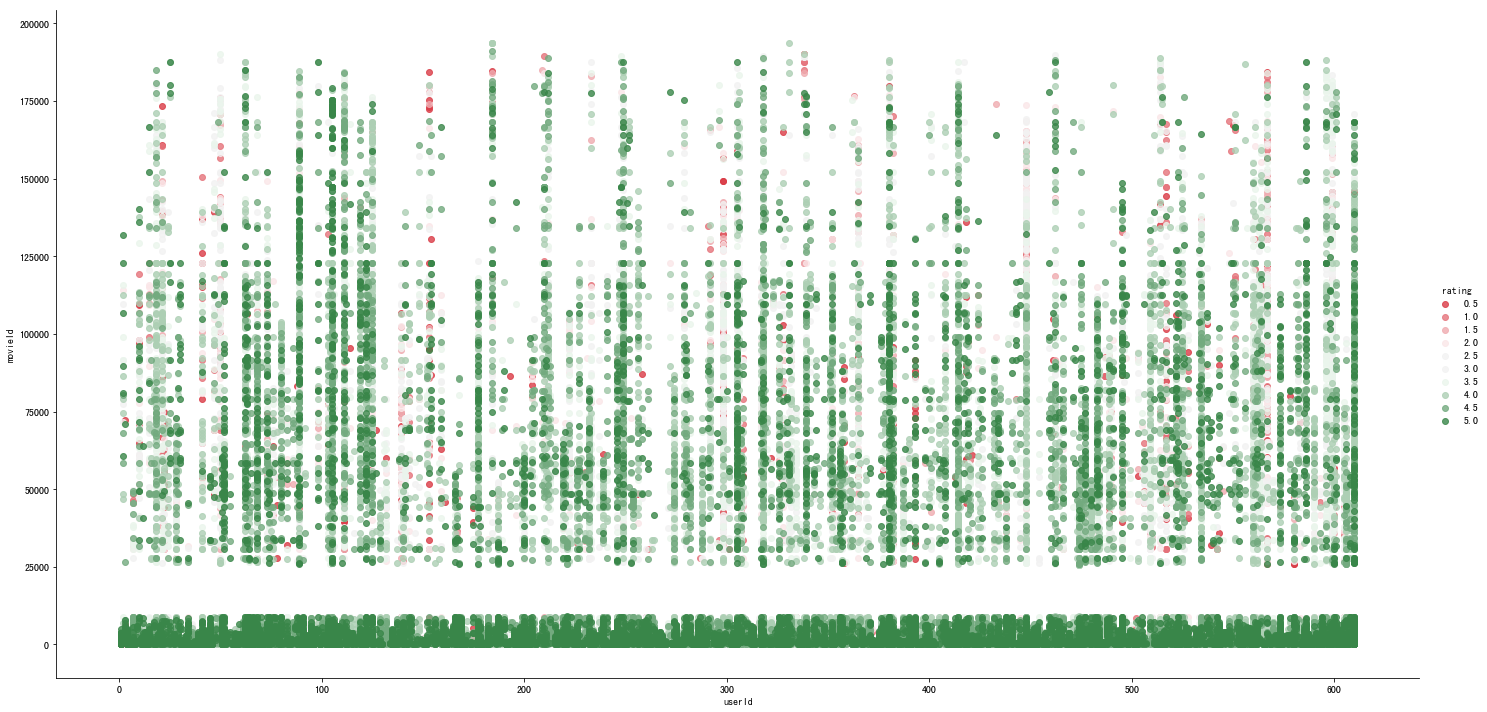

None

In [31]:
sns.lmplot(x="userId",y="movieId",hue="rating",data=ratings_DF,\
           fit_reg=False,height=10,aspect=2,\
           palette=sns.diverging_palette(10,133,sep=80,n=10))
display(plt.show())

In [46]:
# Register the DataFrame as a SQL temporary view
ratings.createOrReplaceTempView("ratings_sql")
spark.sql("""
    SELECT *, 100 * nb_ratings/matrix_size AS percentage
    FROM (
        SELECT nb_users, nb_movies, nb_ratings, nb_users * nb_movies AS matrix_size
        FROM (
            SELECT COUNT(*) AS nb_ratings, COUNT(DISTINCT(movieId)) AS nb_movies, COUNT(DISTINCT(userId)) AS nb_users
            FROM ratings_sql
        )
    )
""").show()

+--------+---------+----------+-----------+------------------+
|nb_users|nb_movies|nb_ratings|matrix_size|        percentage|
+--------+---------+----------+-----------+------------------+
|     610|     9724|    100836|    5931640|1.6999683055613624|
+--------+---------+----------+-----------+------------------+



## Collaborative Filtering by ALS

### 1. Train the model

In [47]:
from pyspark.ml.recommendation import ALS
model= ALS(userCol="userId",itemCol="movieId",ratingCol="rating").fit(ratings)

### 2. Run the model

In [49]:
predictions=model.transform(ratings)
predictions.show(5)

+------+-------+------+---------+----------+
|userId|movieId|rating|timestamp|prediction|
+------+-------+------+---------+----------+
|   191|    148|   5.0|829760897|  4.926102|
|   133|    471|   4.0|843491793| 3.2709658|
|   597|    471|   2.0|941558175| 3.9920049|
|   385|    471|   4.0|850766697| 3.1908472|
|   436|    471|   3.0|833530187| 3.6048405|
+------+-------+------+---------+----------+
only showing top 5 rows



### 3. Evaluate the model

In [51]:
from pyspark.ml.evaluation import RegressionEvaluator

evaluator=RegressionEvaluator(metricName="rmse",labelCol="rating",predictionCol="prediction")

print("the root mean squared error is:",str(evaluator.evaluate(predictions)))

the root mean squared error is: 0.5924476971138315


### 4. Split the data set: avoid overfitting

In [52]:
ratings_train, ratings_test=ratings.randomSplit([0.8, 0.2])

model= ALS(userCol="userId",itemCol="movieId",ratingCol="rating").fit(ratings_train)

predictions=model.transform(ratings_test)

DataFrame[userId: int, movieId: int, rating: double, timestamp: int, prediction: float]

In [53]:
predictions.show(5)

+------+-------+------+----------+----------+
|userId|movieId|rating| timestamp|prediction|
+------+-------+------+----------+----------+
|   217|    471|   2.0| 955943727| 2.7357144|
|   287|    471|   4.5|1110231536| 2.9579911|
|   414|    471|   5.0| 961514069|  3.394865|
|   373|    471|   5.0| 846830388| 3.8986187|
|   599|    833|   1.5|1519330029| 1.0590413|
+------+-------+------+----------+----------+
only showing top 5 rows



#### NAN !!! 

A NaN result is because the model cannot deal with new user, so-called "**cold start**". Two workarounds here:

- exclude rows with predicted NaN values
- replace them with a constant, the general average rating. 

In [54]:
evaluator=RegressionEvaluator(metricName="rmse",labelCol="rating",predictionCol="prediction")
print("the root mean squared error is:",str(evaluator.evaluate(predictions)))

the root mean squared error is: nan


In [55]:
ratings_avg=ratings.select('rating').groupBy().avg().first()[0]
evaluator=RegressionEvaluator(metricName="rmse",labelCol="rating",predictionCol="prediction")
print("the root mean squared error is:",str(evaluator.evaluate(predictions.na.fill(ratings_avg))))

the root mean squared error is: 0.8886338732656414


In [56]:
evaluator=RegressionEvaluator(metricName="rmse",labelCol="rating",predictionCol="prediction")
print("the root mean squared error is:",str(evaluator.evaluate(predictions.na.drop())))

the root mean squared error is: 0.8771120825628923


### 5. Improve the performance

 Two strategies:
 
 - Run ALS several times (random splitting)
 - K fold ALS

In [57]:
import numpy as np
def repeatALS (data, k, userCol="userId", itemCol="movieId", ratingCol="rating", metricName="rmse"):
    evaluations = []
    for i in range(1,k+1):
        train,test = data.randomSplit([k-1.0,1.0])
        model = ALS(userCol="userId", itemCol="movieId", ratingCol="rating").fit(train)
        predictions = model.transform(test)
        evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")
        evaluation = evaluator.evaluate(predictions.na.drop())
        print("Loop",str(i),":",metricName,":",evaluation)
        evaluations.append(evaluation)
    return np.mean(evaluations)

In [58]:
repeatALS(ratings,k=4)

Loop 1 : rmse : 0.8974607534327397
Loop 2 : rmse : 0.8962693281742881
Loop 3 : rmse : 0.8856198802468048
Loop 4 : rmse : 0.884050192698283


0.8908500386380289

In [59]:
def KfoldALS (data, k, userCol="userId", itemCol="movieId", ratingCol="rating", metricName="rmse"):
    evaluations = []
    weights=[1.0]*k
    splits=data.randomSplit(weights)
    for i in range(0,k):
        test=splits[i]
        train=spark.createDataFrame(sc.emptyRDD(),data.schema)
        for j in range(0,k):
            if i==j: continue
            else: train=train.union(splits[j])
        model = ALS(userCol="userId", itemCol="movieId", ratingCol="rating").fit(train)
        predictions = model.transform(test)
        evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")
        evaluation = evaluator.evaluate(predictions.na.drop())
        print("Loop",str(i),":",metricName,":",evaluation)
        evaluations.append(evaluation)
    return np.mean(evaluations)

In [61]:
KfoldALS(ratings,k=4)

Loop 0 : rmse : 0.8849060536259138
Loop 1 : rmse : 0.8836899304838173
Loop 2 : rmse : 0.88818269223352
Loop 3 : rmse : 0.8939634544599508


0.8876855327008004

## Tuning the parameters in ALS by grid search

ALS Hyperparameters:

- rank = the number of latent factors in the model
- maxIter = the maximum number of iterations (fixed at **20** for the following chunk.)
- regParam = the regularization parameter To test several values for those hyperparameters and choose the best configuration, it's common practice to define a grid of parameter combinations and to run a grid search over the combinations to evaluate the resulting models and comparing their performance. This process is known as model selection.

The spark CrossValidator function performs both **grid search** and **k-fold cross-validation**.

In [63]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

ratings_train, ratings_validation = ratings.randomSplit([90.0,10.0])
als = ALS(userCol="userId", itemCol="movieId", ratingCol="rating")
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")

paramGrid = ParamGridBuilder().addGrid(als.rank,[1,5,10]).addGrid(als.maxIter,[20]).\
            addGrid(als.regParam,[0.05,0.1,0.5]).build()
crossval = CrossValidator(estimator=als, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=3)
cvModel = crossval.fit(ratings_train)
preditions = cvModel.transform(ratings_validation)
print("The root mean squared error is:", str(evaluator.evaluate(preditions.na.drop())))

The root mean squared error is: 0.9125384950454948
